In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

All the datasets used in this text are available online at
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

Bayesian Methods for Hackers is designed as an introduction to Bayesian inference from a computational/understanding first, and mathematics second, point of view. Of course, as an introductory book, we can only leave it at that: an introductory book. For the mathematically trained, the curiosity this text generates may be cured by other texts designed with mathematical analysis in mind. For the enthusiast with a less mathematical background, or one who is not interested in the mathematics but simply the practice of Bayesian methods, this text should be sufficient and entertaining.


The choice of PyMC as the probabilistic programming language is twofold. First, as of this writing, there is currently no central resource for examples and explanations in the PyMC universe. The official documentation assumes prior knowledge of Bayesian inference and probabilistic programming. We hope this book encourages users at every level to look at PyMC. Second, with recent core developments and popularity of the scientific stack in Python, PyMC is likely to become a core component soon enough.


The progression of the book is as follows. Chapter 1 introduces Bayesian inference and its comparison to other inference techniques. We also see, build, and train our first Bayesian model. Chapter 2 focuses on building models with PyMC, with a strong emphasis on examples. Chapter 3 introduces Markov Chain Monte Carlo, a powerful algorithm behind computational inference, and some techniques on debugging your Bayesian model. In Chapter 4, we detour and again visit the issue of sample sizes in inference and explain why understanding sample size is so important. Chapter 5 introduces the powerful idea of loss functions, where we have not a model but a function that connects inference to real-world problems. We revisit the idea of Bayesian priors in Chapter 6, and give good heuristics to picking good priors. Finally, in Chapter 7, we explore how Bayesian inference can be used in A/B testing.





### The Philosophy of Bayesian Inference

If you think this way, then congratulations: You already are thinking Bayesian! Bayesian inference is simply updating your beliefs after considering new evidence. A Bayesian can rarely be certain about a result, but he or she can be very confident. Just like in the example above, we can never be 100% sure that our code is bug-free unless we test it on every possible problem, something rarely possible in practice. Instead, we can test it on a large number of problems, and if it succeeds, we can feel more confident about our code, but still not certain. Bayesian inference works identically: We update our beliefs about an outcome, but rarely can we be absolutely sure unless we rule out all other alternatives.

Bayesian inference differs from more traditional statistical inference by preserving uncertainty. At first, this sounds like a bad statistical technique. Isn’t statistics all about deriving certainty from randomness? To reconcile this, we need to start thinking like Bayesians.
The Bayesian worldview interprets probability as measure of believability in an event—that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability.

For this to be clearer, we consider an alternative interpretation of probability: Frequentists, who ascribe to the more classical version of statistics, assume that probability is the long-run frequency of events (hence the name). For example, the probability of plane accidents under a frequentist philosophy is interpreted as the long-term frequency of plane accidents. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: We often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying that across all these realities, the frequency of occurrences defines the probability.

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as the measure of belief, or confidence, in an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event believes with absolute certainty that the event will not occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain that the event will occur. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the example of the probability of a plane accident occurring, for having observed the frequency of plane accidents, an individual’s belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: How confident are you that candidate A will win?

Notice that in the preceding paragraph, I assigned the belief (probability) measure to an individual, not to nature. This is very interesting, as this definition leaves room for conflicting beliefs between individuals. Again, this is analogous to what naturally occurs: Different individuals have different beliefs of events occurring because they possess different information about the world. The existence of different beliefs does not imply that anyone is wrong.

To align ourselves with traditional probability notation, we denote our belief about event A as P(A). We call this quantity the prior probability.

John Maynard Keynes, a great economist and thinker, is often quoted (perhaps apocryphally) as saying, “When the facts change, I change my mind. What do you do, sir?” This quotation reflects the way a Bayesian updates his or her beliefs after seeing evidence. Even—especially—if the evidence is counter to what was initially believed, the evidence cannot be ignored. We denote our updated belief as P(A|X), interpreted as the probability of A given the evidence X. We call the updated belief the posterior probability so as to contrast it with the prior probability.

As we acquire more and more instances of evidence, our prior belief is “washed out” by the new evidence. This is to be expected. For example, if your prior belief is something ridiculous like “I expect the sun to explode today,” and each day you are proved wrong, you would hope that any inference would correct you, or at least align your beliefs better. Bayesian inference will correct this belief.

Denote N as the number of instances of evidence we possess. As we gather an infinite amount of evidence, say as N → ∞, our Bayesian results (often) align with frequentist results. Hence for large N, statistical inference is more or less objective. On the other hand, for small N, inference is much more unstable; frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels. By introducing a prior, and returning probabilities (instead of a scalar estimate), we preserve the uncertainty that reflects the instability of statistical inference of a small-N dataset.


One may think that for large N, one can be indifferent between the two techniques since they offer similar inference, and might lean toward the computationally simpler frequentist methods. An individual in this position should consider the following quotation by Andrew Gelman (2005)[1] before making such a decision:
Sample sizes are never large. If N is too small to get a sufficiently-precise estimate, you need to get more data (or make more assumptions). But once N is “large enough,” you can start subdividing the data to learn more (for example, in a public opinion poll, once you have a good estimate for the entire country, you can estimate among men and women, northerners and southerners, different age groups, etc). N is never enough because if it were “enough” you’d already be on to the next problem for which you need more data.


The much more difficult analytic problems involve medium data and—especially troublesome—really small data. Using an argument similar to Gelman’s, if big-data problems are big enough to be readily solved, then we should be more interested in the not-quite-big-enough datasets.


## Our Bayesian Framework

We are interested in beliefs, which can be interpreted as probabilities by thinking Bayesian. We have a prior belief in event A - for example, our prior belief about bugs being in our code before performing tests.

Next, we observe our evdience. To continue our buggy-code example: If our code passes X tests, we want ot update our belief to incorporate this. We cann this new belief the _posterior probability_. Updating our belief is done via the following equation, known as Bayes's Theorem, after its discoverer Thomas Bayes:

$
P(A|X) = \frac{P(X|A)P(A)}{P(X)} \propto P(X|A)P(A)
$

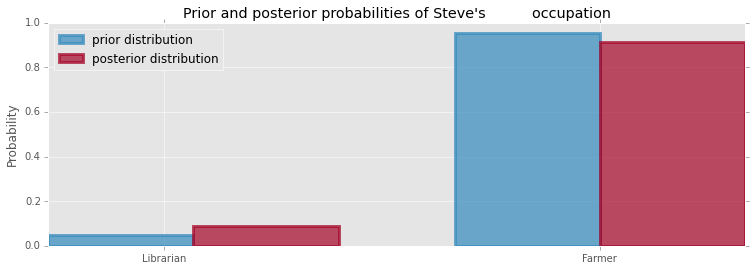

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(12.5, 4)
colors = ["#348ABD", "#A60628"]
prior = [1/21., 20/21.]
posterior = [0.087,1-0.087]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
        color=colors[0], label="prior distribution",
        lw="3", edgecolor="#348ABD")

plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
        width=0.25, color=colors[1],
        label="posterior distribution",
        lw="3", edgecolor="#A60628")

plt.xticks([0.20, 0.95], ["Librarian", "Farmer"])
plt.title("Prior and posterior probabilities of Steve's\
          occupation")
plt.ylabel("Probability")
plt.legend(loc="upper left");

In [3]:
colors = ["#348ABD", "#A60628"]

In [4]:
prior = [1/21., 20/21.]

In [5]:
import scipy.stats as stats

We say that $Z$ is Poisson-distributed if:

$
P(Z=k) = \frac{\lambda^{k} e^{-\lambda}}{k !}, k=0, 1, 2, \cdots
$


If a random variable $Z$ has a Poisson mass distribution, we denote this by writing

$
Z \sim \mbox{Poi}(\lambda)
$

One useful property of the Poisson distibution is that its expected value is equal to its parameter.
That is,
$ 
E[Z|\lambda] = \lambda
$

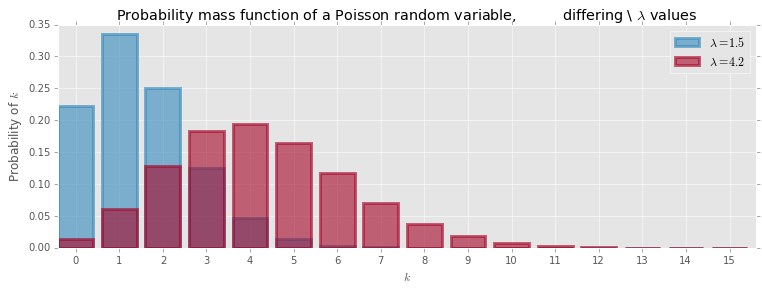

In [6]:
figsize(12.5, 4)
import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colors = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
        label="$\lambda = %.1f $" % lambda_[0], alpha=0.60,
        edgecolor=colors[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
        label="$\lambda = %.1f $" % lambda_[1], alpha=0.60,
        edgecolor=colors[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("Probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable,\
          differing \ $\lambda$ values");

In [7]:
a = np.arange(100)

In [8]:
poi = stats.poisson

In [9]:
duh = poi.pmf(a, 50)

In [10]:
duhseries = pd.Series(duh, index=a)

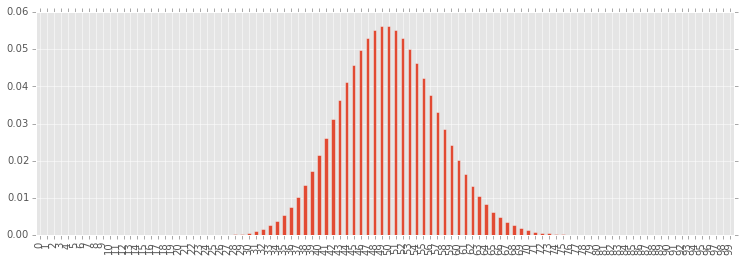

In [11]:
duhseries.plot(kind='bar')

An example of a continuous random variable is a random variable with _exponential density_. The density function for an exponential random variable looks like this:

$
\lambda e^{-\lambda z}, z \geq 0
$


When a random variable Z has an exponential distribution with parameter $\lambda$, we say $Z$ is exponential and write
$
Z \sim \mbox{Exp}(\lambda)
$  

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$. That is,

$
E[Z|\lambda] = \frac{1}{\lambda}
$


In [12]:
a = np.linspace(0,4,300)
expo = stats.expon

In [52]:
supduh = expo.pdf(a, scale=1/4.)

In [53]:
dumsupduh = pd.Series(supduh, index=a)

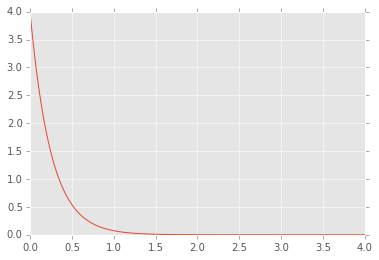

In [54]:
dumsupduh.plot()

C:\Users\ddooling\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


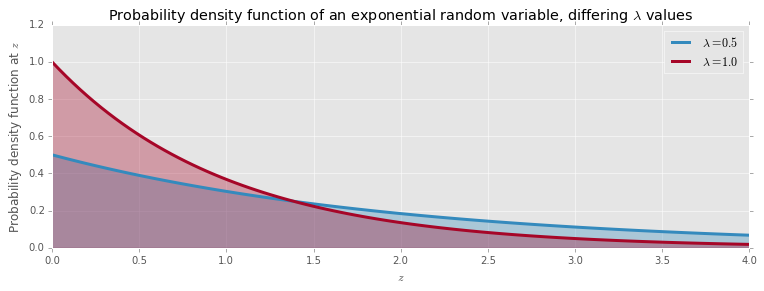

In [17]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f $" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("Probability density function at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an exponential random " + 
          "variable, differing $\lambda$ values");

### Using Computers to Perform Bayesian Inference for Us

Example: Inferring Behavior from Text-Message Data

In [55]:
count_data = np.loadtxt("data/txtdata.csv")

In [56]:
count_data

array([ 13.,  24.,   8.,  24.,   7.,  35.,  14.,  11.,  15.,  11.,  22.,
        22.,  11.,  57.,  11.,  19.,  29.,   6.,  19.,  12.,  22.,  12.,
        18.,  72.,  32.,   9.,   7.,  13.,  19.,  23.,  27.,  20.,   6.,
        17.,  13.,  10.,  14.,   6.,  16.,  15.,   7.,   2.,  15.,  15.,
        19.,  70.,  49.,   7.,  53.,  22.,  21.,  31.,  19.,  11.,  18.,
        20.,  12.,  35.,  17.,  23.,  17.,   4.,   2.,  31.,  30.,  13.,
        27.,   0.,  39.,  37.,   5.,  14.,  13.,  22.])

In [57]:
countdataseries = pd.Series(count_data)

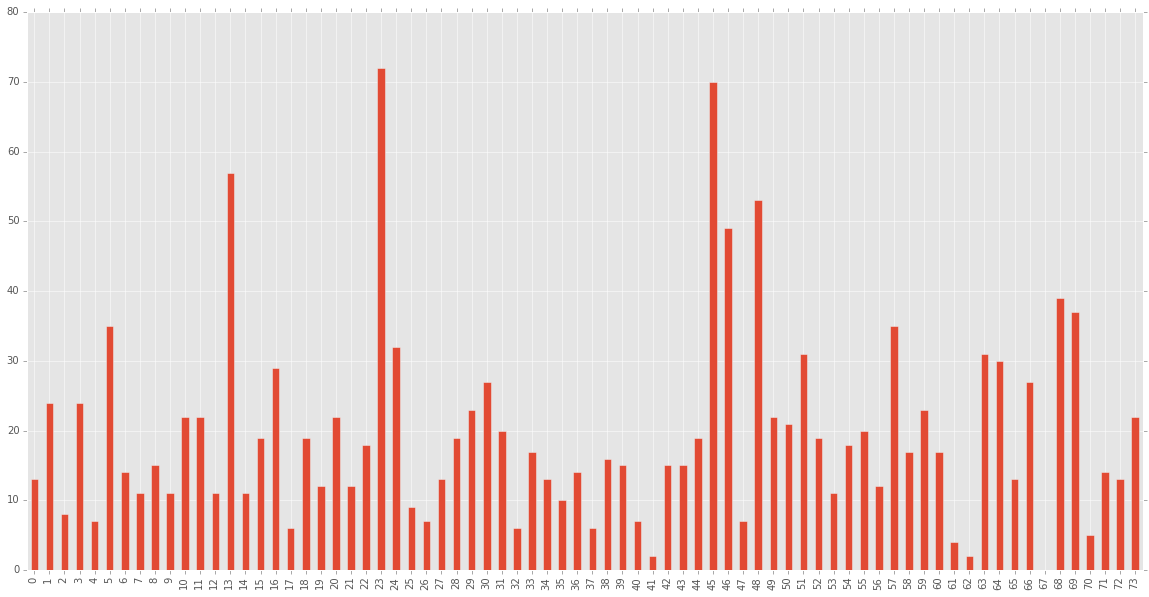

In [58]:
countdataseries.plot(kind='bar',figsize=(20,10))

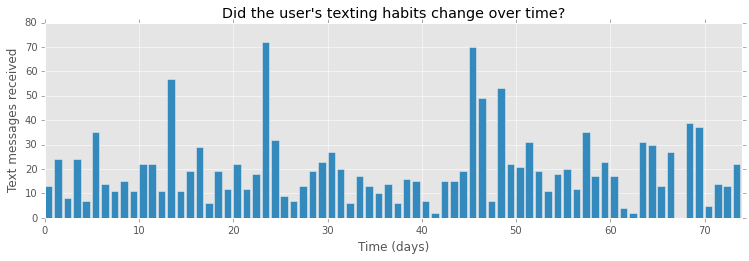

In [18]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Before we start modeling, see what you can figure out just by looking at Figure 1.4.1. Would you say there was a change in behavior during this time period?

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of count data. Denoting day i’s text-message count by Ci,

$
C_{i} \sim \mbox{Poi}(\lambda)
$

We are not sure what the value of the λ parameter really is, however. Looking at Figure 1.4.1, it appears that the rate might become higher late in the observation period, which is equivalent to saying that λ increases at some point during the observations. (Recall that a higher value of λ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)


How can we represent this observation mathematically? Let’s assume that on some day during the observation period (call it τ), the parameter λ suddenly jumps to a higher value. So we really have two λ parameters: one for the period before τ, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:

PyMC is a Python library for programming Bayesian analysis.[5] It is a fast, well-maintained library. The only unfortunate part is that its documentation is lacking in certain areas, especially those that bridge the gap between beginner and hacker. One of this book’s main goals is to solve that problem, and also to demonstrate why PyMC is so cool.

We will model this problem using PyMC. This type of programming is called probabilistic programming, an unfortunate misnomer that invokes ideas of randomly generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model’s components. Model components are first-class primitives within the PyMC framework.

PyMC code is easy to read. The only novel thing should be the syntax, and I will interrupt the code to explain individual sections. Simply remember that we are representing the model’s components (τ, λ1, λ2) as variables:


In [40]:
import pymc as pm
alpha = 1.0/count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [41]:
print "Random output:", tau.random(), tau.random(), tau.random() 

Random output: 51 25 22


In [42]:
import pymc as pm
n_count_data = len(count_data)

In [44]:
alpha = 1.0/count_data.mean()  # Recall that count_data is the 
                               # variable that holds our text counts. 
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data))

In [45]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data) # number of data points 
    out[:tau] = lambda_1  # lambda before tau is lambda_1 
    out[tau:] = lambda_2  # lambda after (and including) tau is 
                          # lambda_2 
    return out

In [46]:
observation = pm.Poisson("obs", lambda_, value=count_data,
                         observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [47]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 3.4 sec

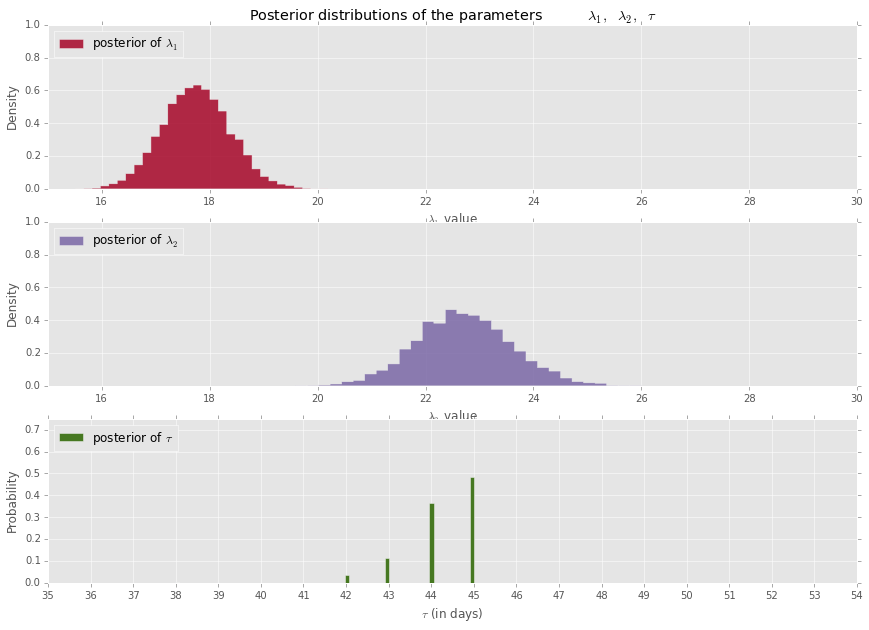

In [48]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

fig = plt.figure(figsize=(14.5,10))

#figsize(14.5, 10)
# histogram of the samples 

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
          $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");

In [50]:
lambda_1_samples.mean()

17.748272462259791

In [51]:
lambda_2_samples.mean()

22.711840876061409

## What good are samples from the posterior, anyway?

We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some powerful results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: What is the expected number of texts at day t, $0 \leq t \leq 70$?
Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$.

[ 17.78326153  17.78326153  17.78326153  17.78326153  17.78326153
  17.78326153  17.78326153  17.78326153  17.78326153  17.78326153
  17.78326153  17.78326153  17.78326153  17.78326153  17.78326153
  17.78326153  17.78326153  17.78326153  17.78326153  17.78326153
  17.78326153  17.78326153  17.78326153  17.78326153  17.78326153
  17.78326153  17.78326153  17.78326386  17.78321628  17.78308395
  17.7831063   17.78299946  17.78295907  17.78302621  17.78291689
  17.78291689  17.78323482  17.78325664  17.783704    17.78403186
  17.78473245  17.78883783  17.94317776  18.45146045  20.27883996
  22.71281506  22.71294134  22.71294134  22.71294134  22.71294134
  22.71294134  22.71294134  22.71294134  22.71294134  22.71294134
  22.71294134  22.71294134  22.71294134  22.71294134  22.71294134
  22.71294134  22.71294134  22.71294134  22.71294134  22.71294134
  22.71294134  22.71294134  22.71294134  22.71294134  22.71294134
  22.71294134  22.71294134  22.71294134  22.71294134]


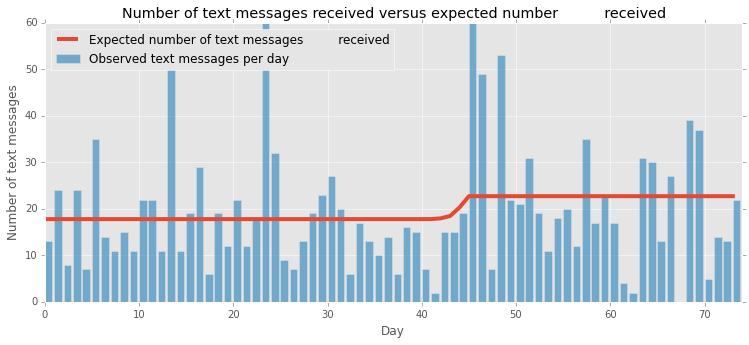

In [29]:
figsize(12.5, 5)
    # tau_samples, lambda_1_samples, lambda_2_samples contain 
    # N samples from the corresponding posterior distribution. 
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data) # number of data points 
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to 
    # the switchpoint occurring prior to value of "day." 
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau. 
    # For each day, that value of tau indicates whether we're 
    # "before" 
    # (in the lambda_1 "regime") or 
    # "after" (in the lambda_2 "regime") the switchpoint. 
    # By taking the posterior sample of lambda_1/2 accordingly,
    # we can average 
    # over all samples to get an expected value for lambda on that day. 
    # As explained, the "message count" random variable is 
    # Poisson-distributed, 
    # and therefore lambda (the Poisson parameter) is the expected 
    # value of 
    # "message count." 
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()\
                                   + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4,
         color="#E24A33", label="Expected number of text messages\
         received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Number of text messages")
plt.title("Number of text messages received versus expected number\
          received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD",
        alpha=0.65, label="Observed text messages per day")
plt.legend(loc="upper left")
print expected_texts_per_day



In [31]:
print (lambda_1_samples < lambda_2_samples)

[ True  True  True ...,  True  True  True]


In [32]:
print (lambda_1_samples < lambda_2_samples).sum()

29986


In [33]:
print lambda_1_samples.shape[0]

30000


In [34]:
print (lambda_1_samples < lambda_2_samples).mean()

0.999533333333


In [35]:
# The vector abs(lambda_1_samples - lambda_2_samples) > 1 is a boolean, 
# True if the values are more than 1 apart, False otherwise. 
# How often does this happen? Use .mean() 
for d in [1,2,5,10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print "What is the probability the difference is larger than %d \
          ? %.2f "%(d,v)

What is the probability the difference is larger than 1           ? 1.00 
What is the probability the difference is larger than 2           ? 0.99 
What is the probability the difference is larger than 5           ? 0.48 
What is the probability the difference is larger than 10           ? 0.00 


In [38]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2,
            lambda_1=lambda_1, lambda_2=lambda_2, lambda_3 = lambda_3):
    out = np.zeros(n_count_data) # number of data points 
    out[:tau_1] = lambda_1 # lambda before tau is lambda_1 
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3 # lambda after (and including) tau
                           # is lambda_2 
    return out

observation = pm.Poisson("obs", lambda_, value=count_data,
                         observed=True)

model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1,
                  tau_2])
mcmc = pm.MCMC(model)
mcmc.sample(50000, 10000)


 [-----------------100%-----------------] 50000 of 50000 complete in 7.4 sec

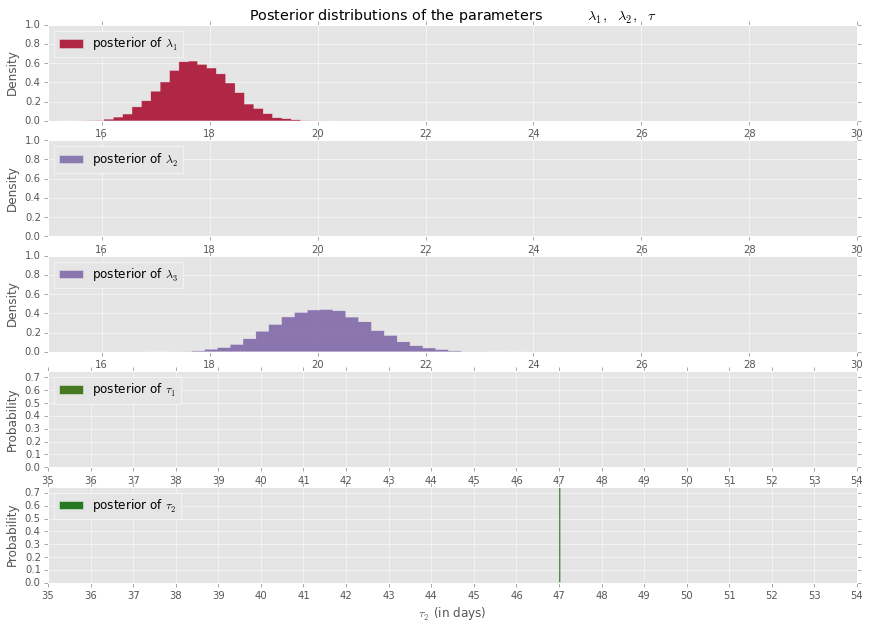

In [39]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

fig = plt.figure(figsize=(14.5,10))

#figsize(14.5, 10)
# histogram of the samples 

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
          $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")


ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#7A61A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_3$ value")
plt.ylabel("Density")

plt.subplot(514)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_1$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_1$ (in days)")
plt.ylabel("Probability")

plt.subplot(515)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)
plt.hist(tau_2_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_2$", color="#267821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau_2$ (in days)")
plt.ylabel("Probability");





In [30]:
import pymc as pm

p = pm.Uniform('p', lower=0, upper = 1)

In [85]:
# set constants 
p_true = 0.05 # remember, this is unknown in real-life 
N = 55000

# Sample N Bernoulli random variables from Ber(0.05). 
# Each random variable has a 0.05 chance of being a 1. 
# This is the data-generation step. 
occurrences = pm.rbernoulli(p_true, N)

print(occurrences) # Remember: Python treats True == 1, and False == 0. 
print(occurrences.sum())

[False False False ..., False False False]
2750


In [86]:
# Occurrences.mean() is equal to n/N. 
print("What is the observed frequency in Group A? %.4f " % occurrences.mean())
print("Does the observed frequency equal the true frequency? %s "  % (occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0500 
Does the observed frequency equal the true frequency? True 


In [87]:
# Include the observations, which are Bernoulli. 
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# to be explained in Chapter 3 
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)



 [-----------------100%-----------------] 20000 of 20000 complete in 9.2 sec

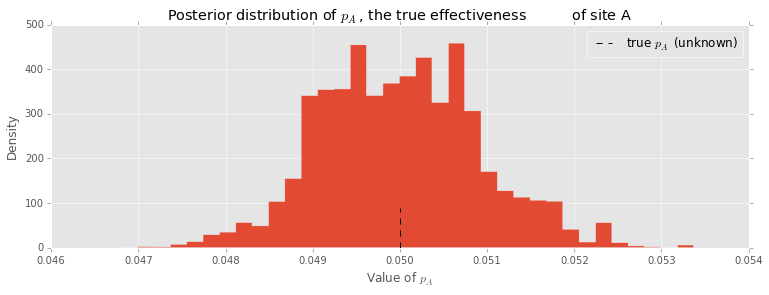

In [88]:
fig = plt.figure(figsize=(12.5,4))
plt.title("Posterior distribution of $p_A$, the true effectiveness\
          of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled",
         normed=True)
plt.xlabel("Value of $p_A$")
plt.ylabel("Density")
plt.legend();